In [64]:
# import packages
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import xarray as xr
import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

from graphviz import Source

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# setting up figure parameters
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (15.0/2, 20.0/2)

In [4]:
def GlobalMean(data, lat_ori, lon_ori):
    datanew = ma.masked_array(data, np.isnan(data))
    
    # calculate weights
    rr = np.deg2rad(6371220.0) # the number is Earth's radius

    dlon = np.abs(lon_ori[2] - lon_ori[1])*rr
    dx = dlon*np.cos(np.deg2rad(lat_ori))

    dy = np.empty(len(lat_ori))
    dy[:] = np.nan

    dy[0] = np.abs(lat_ori[2] - lat_ori[1])*rr
    dy[1:-1] = np.abs(lat_ori[2::] - lat_ori[0:-2])*rr*0.5
    dy[-1] = np.abs(lat_ori[-1] - lat_ori[-2])*rr

    area = dx*dy
    weight = np.broadcast_to(area, (len(lon_ori), len(lat_ori))).T
    
    # calculate weighted average
    result = []
    if data.ndim > 2:
        for i in np.arange(0, len(data)):
            tmp = ma.average(datanew[i,:,:], weights=weight)
            result.append(tmp)
    else:
        tmp = ma.average(datanew, weights=weight)
        result.append(tmp)
        
    return result

# Data preparation

In [5]:
# read in data
ORAp_t = 'sosstsst_control_regrid_monthly_3D_195801-201412.nc'
ORAp_h = 'sossheig_control_regrid_monthly_3D_195801-201412.nc'
ORAp_s = 'sosaline_control_regrid_monthly_3D_195801-201412.nc'
ORAp_m = 'somxl030_control_regrid_monthly_3D_195801-201412.nc'

ORA_SST = nc.Dataset(ORAp_t).variables['sst'][:]
ORA_SSH = nc.Dataset(ORAp_h).variables['ssh'][:]
ORA_SSS = nc.Dataset(ORAp_s).variables['sss'][:]
ORA_MLD = nc.Dataset(ORAp_m).variables['mxl'][:]

monthofYear = np.arange(1, np.shape(ORA_SST)[0]+1)
 
lat = nc.Dataset(ORAp_t).variables['lat'][:] #all nc files are regridded to same latlon values
lon = nc.Dataset(ORAp_t).variables['lon'][:]

In [133]:
# calculate global-mean
Osst_GM = GlobalMean(ORA_SST, lat, lon)
Ossh_GM = GlobalMean(ORA_SSH, lat, lon)
Osss_GM = GlobalMean(ORA_SSS, lat, lon)
Omld_GM = GlobalMean(ORA_MLD, lat, lon)

# calculate mld climatology for future evaluation use
Omld_GMc = np.nanmean(np.array(Omld_GM).reshape((12, int(len(Omld_GM)/12))), axis=1)
baseline = np.tile(Omld_GMc, int(len(Omld_GM)/12))

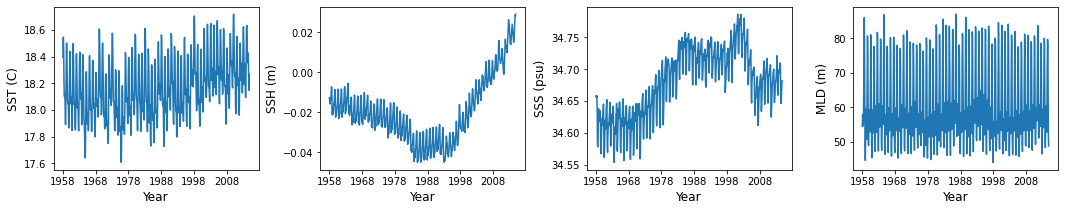

In [7]:
# visualize the timeseries
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18,3))
gs = gridspec.GridSpec(1, 4, figure=fig)

for j in np.arange(0,4):
    axs[j] = plt.subplot(gs[j])
    axs[j].set_xlabel('Year')
    axs[j].set_xticks(np.arange(0,len(Osst_GM),120), np.arange(1958,2014,10))

axs[0].set_ylabel('SST (C)')
axs[1].set_ylabel('SSH (m)')
axs[2].set_ylabel('SSS (psu)')
axs[3].set_ylabel('MLD (m)')

axs[0].plot(Osst_GM)
axs[1].plot(Ossh_GM)
axs[2].plot(Osss_GM)
axs[3].plot(Omld_GM)
        
fig.subplots_adjust(wspace=0.3)

# plt.savefig('./storyline/Fig3.pdf', bbox_inches='tight')
plt.show()

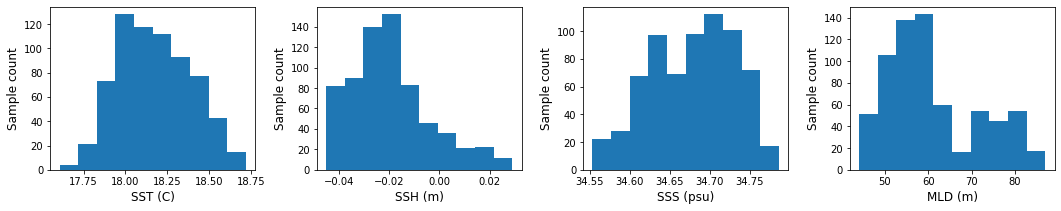

In [41]:
# check timeseries distribution
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18,3))
gs = gridspec.GridSpec(1, 4, figure=fig)

for j in np.arange(0,4):
    axs[j] = plt.subplot(gs[j])
    axs[j].set_ylabel('Sample count')

axs[0].set_xlabel('SST (C)')
axs[1].set_xlabel('SSH (m)')
axs[2].set_xlabel('SSS (psu)')
axs[3].set_xlabel('MLD (m)')

axs[0].hist(Osst_GM)
axs[1].hist(Ossh_GM)
axs[2].hist(Osss_GM)
axs[3].hist(Omld_GM)
        
fig.subplots_adjust(wspace=0.3)
plt.show()

In [65]:
# predictors and predictand
X = np.empty((len(Osst_GM), 4))
X[:,:] = np.nan

X[:,0] = monthofYear
X[:,1] = Osst_GM
X[:,2] = Ossh_GM
X[:,3] = Osss_GM

y = np.copy(Omld_GM)

# Train/test set

In [66]:
# spliting train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # how to do no-shuffle?

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # what's the differences? Why can't I do a scaler onto the whole timeseries?
X_test_scaled = scaler.transform(X_test)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Training Features Shape: (513, 4)
Testing Features Shape: (171, 4)


# Built a decision tree model to predict MLD by using surface variables

In [105]:
# Train the model
tree_depth = 8
node_split = 2  # minimum number of training samples needed to split a node
leaf_samples = 8  # minimum number of training samples required to make a leaf node
RAND_STATE = 42

tree_clf = DecisionTreeRegressor(max_depth=tree_depth,
                                 min_samples_split=node_split,
                                 min_samples_leaf=leaf_samples,
                                 random_state=RAND_STATE,
                                 criterion="squared_error")  # 'gini' for classifier

tree_clf.fit(X_train, y_train)
# tree_clf.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=8, random_state=42)

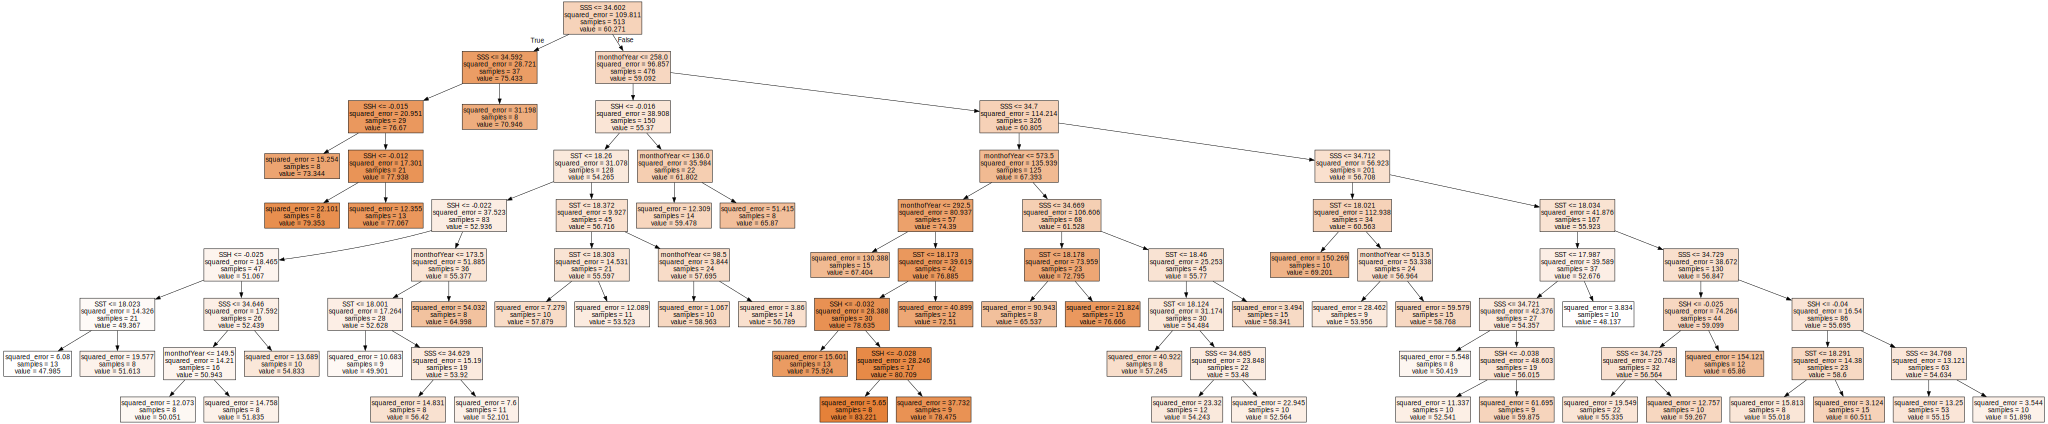

In [106]:
# visualize how the tree looks like
fig_savename = "MLD_regressor"

if len(np.shape(tree_clf)) != 0:
    tree_to_viz = tree_clf[0]  # this line sets which decision tree out of your RF you want to plot
else:
    tree_to_viz = tree_clf
    
export_graphviz(tree_to_viz,
                out_file='./' + fig_savename + ".dot",
                filled=True,
                proportion=False,
                leaves_parallel=False,
                class_names=label_names,
                feature_names=feature_list)

Source.from_file('./' + fig_savename + ".dot")

# Make a prediction

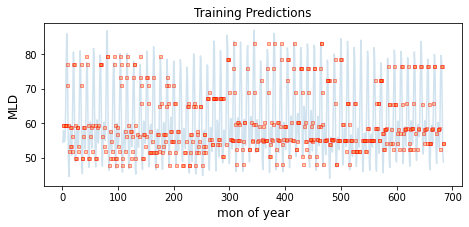

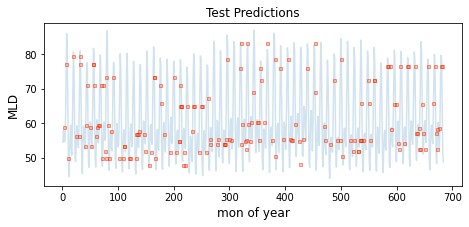

In [101]:
# visualize the predictions
for split_type in ("Training", "Test"):
    if split_type == "Training":
        plot_features = X_train
        plot_pred = y_pred_train
    elif split_type == "Test":
        plot_features = X_test
        plot_pred = y_pred_test
    else:
        raise NotImplementedError()

    fig, ax = plt.subplots(figsize=(7.5, 3))

    ax.plot(X[:,0], Omld_GM, alpha=0.2)
    ax.plot(plot_features[:,0], plot_pred, "s", markersize=3, alpha=0.4, linewidth=0.1, markeredgecolor="r")
    ax.set_xlabel("mon of year")
    ax.set_ylabel("MLD")

    plt.title(split_type + " Predictions")
    plt.show()